In [12]:
import numpy
import pandas
import sklearn
import sklearn.tree

converters = { 'Embarked': lambda s: s if s != '' else 'Unknown' }
df = pandas.read_csv('data/titanic-train.csv', na_filter=True, converters = converters)
df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
d = {}
for v in df['Embarked']:
    d[v] = True
print(d.keys())


sex_codec = sklearn.preprocessing.LabelEncoder()
embarked_codec = sklearn.preprocessing.LabelBinarizer()
imputer = sklearn.preprocessing.Imputer()

sex_codec.fit(df['Sex'])
embarked_codec.fit(df['Embarked'])

embarked_columns = ['embarked_' + (s if s != '' else 'unknown')
                    for s in embarked_codec.classes_]

df['Sex']= sex_codec.fit_transform(df['Sex'])

df = pandas.concat([df, pandas.DataFrame(embarked_codec.fit_transform(df['Embarked']), columns=embarked_columns)], axis=1)
df.head(5)


['Q', 'Unknown', 'S', 'C']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,embarked_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0


In [14]:
feature_names = ['Pclass', 'Sex', 
            'Age', 'SibSp', 'Parch', 'Fare',
            'embarked_Unknown', 'embarked_C', 'embarked_Q', 'embarked_S']
features = imputer.fit_transform(df[feature_names])



 # Modify Tuning Parameters Here

In [15]:
target = df['Survived']
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=None,
                                                 max_leaf_nodes=3,
                                                 max_features=None)
classifier.fit(features, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=3, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

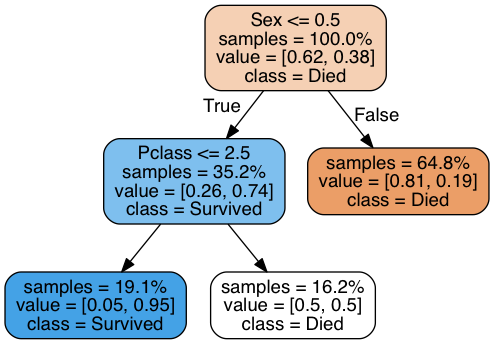

In [16]:
import pydotplus
from IPython.display import Image  
sklearn.tree.export_graphviz(classifier, out_file='tree.dot',
                             class_names = ['Died', 'Survived'],
                             proportion=True,
                             filled=True,
                             leaves_parallel=False,
                             impurity=False,
                             rounded=True,
                         feature_names=feature_names) 
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())  
